In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])

# Overview
Data is contained in a csv exported by Huckleberry on 2026-02-16. There will be missing and inaccurate data due to my wife and I being new, sleep-deprived parents. The main columns are the type of information (diaper, feed, sleep, pump, tummy time, bath, growth, and temp). I will be focusing mainly on feed and sleep. Each of these will also have a start time, some will have an end time with a duration, and then optionally a start/end condition, and a start location.

In [168]:
baby_df['Type'].unique()

array(['Diaper', 'Feed', 'Sleep', 'Pump', 'Tummy time', 'Bath', 'Growth',
       'Temp'], dtype=object)

In [169]:
baby_df = pd.read_csv('data/Baby_Huckleberry_Data--2026-02-16.csv')

In [170]:
baby_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798 entries, 0 to 1797
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Type             1798 non-null   object
 1   Start            1798 non-null   object
 2   End              557 non-null    object
 3   Duration         671 non-null    object
 4   Start Condition  948 non-null    object
 5   Start Location   570 non-null    object
 6   End Condition    1066 non-null   object
 7   Notes            61 non-null     object
dtypes: object(8)
memory usage: 112.5+ KB


In [171]:
baby_df.head()

,Type,Start,End,Duration,Start Condition,Start Location,End Condition,Notes
0,Diaper,2026-02-16 13:42,NaN,NaN,NaN,NaN,Pee,NaN
1,Feed,2026-02-16 12:36,NaN,NaN,Breast Milk,Bottle,4oz,NaN
2,Sleep,2026-02-16 12:02,2026-02-16 12:30,00:28,NaN,NaN,NaN,NaN
3,Sleep,2026-02-16 11:47,2026-02-16 11:58,00:11,NaN,NaN,NaN,NaN
4,Diaper,2026-02-16 11:36,NaN,NaN,NaN,NaN,Pee,NaN


# Sleep and Feed Data
I will convert the Start and End values to datetimes for easier manipulation and then calculate the sleep duration in minutes. For the feeds, the End Condition contains the volume of the feed in either mL or oz. For simplicity, I will convert all of them to mL.
Note that many of the feed volumes are identical since my wife and I get to choose the feed amount ourselves and our son tends to eat everything we give him.

In [172]:
baby_df['Start'] = pd.to_datetime(baby_df['Start'])
baby_df['End'] = pd.to_datetime(baby_df['End'])

is_sleep = baby_df['Type'] == 'Sleep'
baby_df.loc[is_sleep, 'Sleep_Duration'] = pd.to_timedelta(baby_df.loc[is_sleep, 'Duration'] + ':00').dt.total_seconds() / 60

is_feed = baby_df['Type'] == 'Feed'
baby_df.loc[is_feed, 'Feed_mL'] = pd.to_numeric(baby_df.loc[is_feed, 'End Condition'].str.extract(r'(\d+\.?\d*)')[0])
is_oz = is_feed & baby_df['End Condition'].str.contains('oz', case=False)
baby_df.loc[is_oz, 'Feed_mL'] *= 29.57

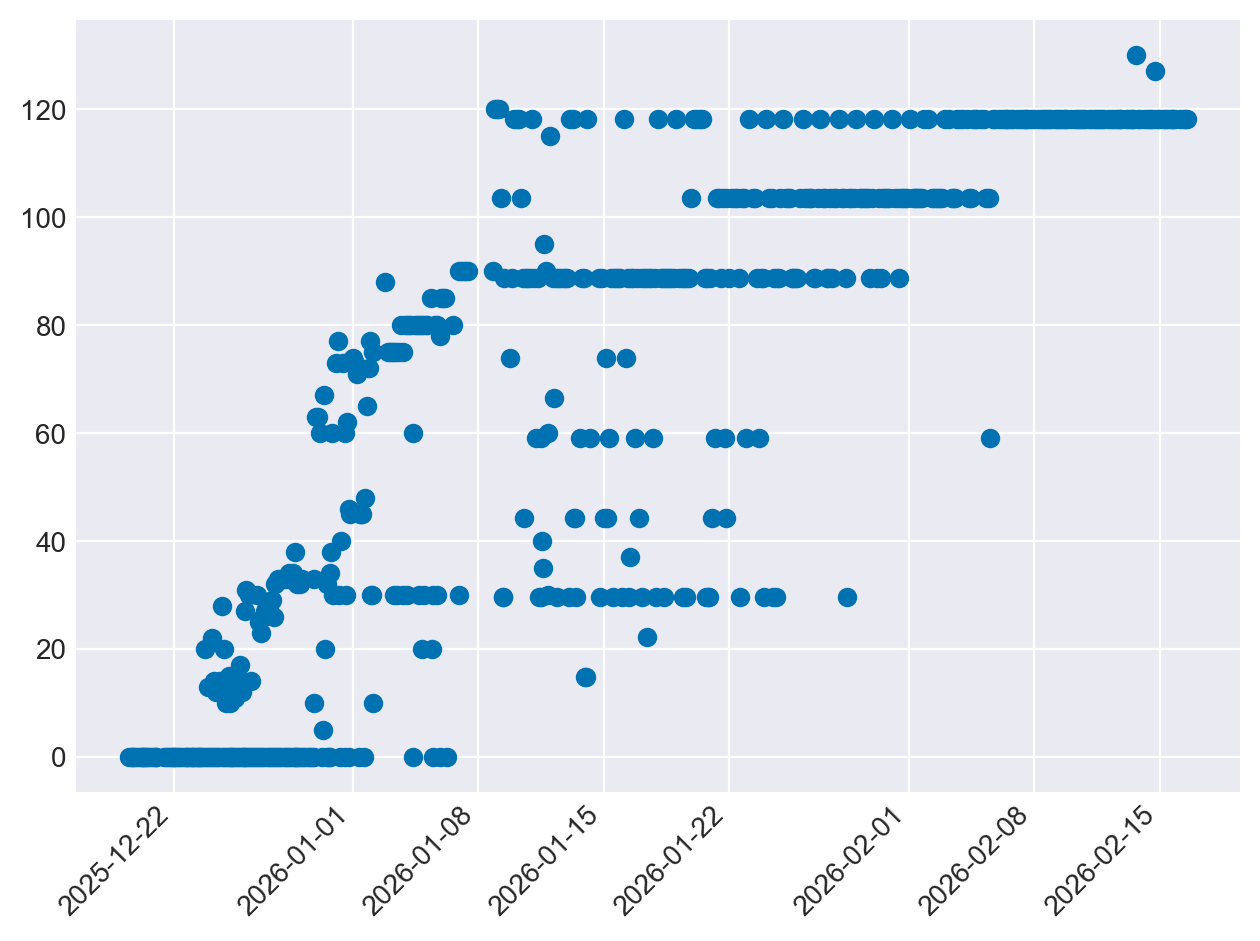

In [173]:
plt.scatter(baby_df['Start'], baby_df['Feed_mL'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [174]:
baby_df['Feed_mL'] = baby_df['Feed_mL'].replace(0, np.nan)
baby_df['Feed_mL_norm'] = (baby_df['Feed_mL'] - baby_df['Feed_mL'].mean()) / baby_df['Feed_mL'].std()
baby_df['Days'] = (baby_df['Start'] - baby_df['Start'].min()).dt.days
baby_df['Days_norm'] = (baby_df['Days'] - baby_df['Days'].mean()) / baby_df['Days'].std()

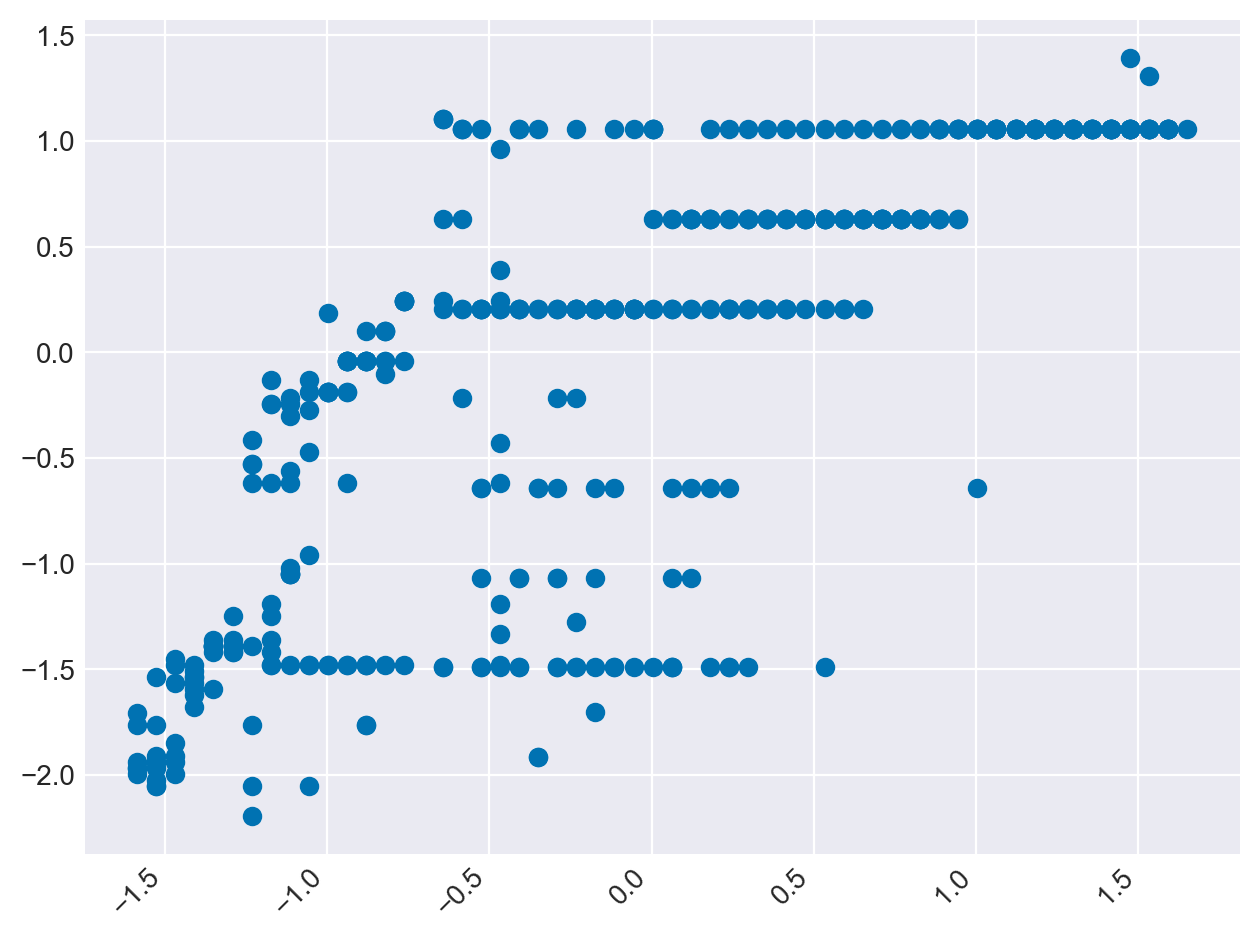

In [175]:
plt.scatter(baby_df['Days_norm'], baby_df['Feed_mL_norm'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Feed Volume Over Time
## Model and Priors
As a start with this dataset, I will be fitting a logistic curve to model the feed volumes. The days and feed volumes have been normalized in this model. Priors were chosen to give a loose approximation to the range of the data.

There are several divergences during the fit, but rhat values are all at 1 so I would consider the fit space well-explored.

In [314]:
import pymc as pm

baby_feed_df = baby_df.dropna(subset=['Days_norm', 'Feed_mL_norm'])

with pm.Model() as eating_model:
    days = pm.Data('days', baby_feed_df['Days_norm'].values)
    feed_obs = pm.Data('feed_obs', baby_feed_df['Feed_mL_norm'].values)

    a = pm.Normal('a', mu=0, sigma=1)
    L = pm.TruncatedNormal('L', lower=2, mu=4, sigma=1)
    k = pm.TruncatedNormal('k', lower=0.3, mu=2, sigma=1)
    x0 = pm.Normal('x0', mu=0, sigma=1)
    
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', L / (1 + pm.math.exp(-k * (days - x0))) + a)
    feed = pm.Normal('feed', mu=mu, sigma=sigma, observed=feed_obs, shape=days.shape)

    idata_eating = pm.sample_prior_predictive(draws=100)

Sampling: [L, a, feed, k, sigma, x0]


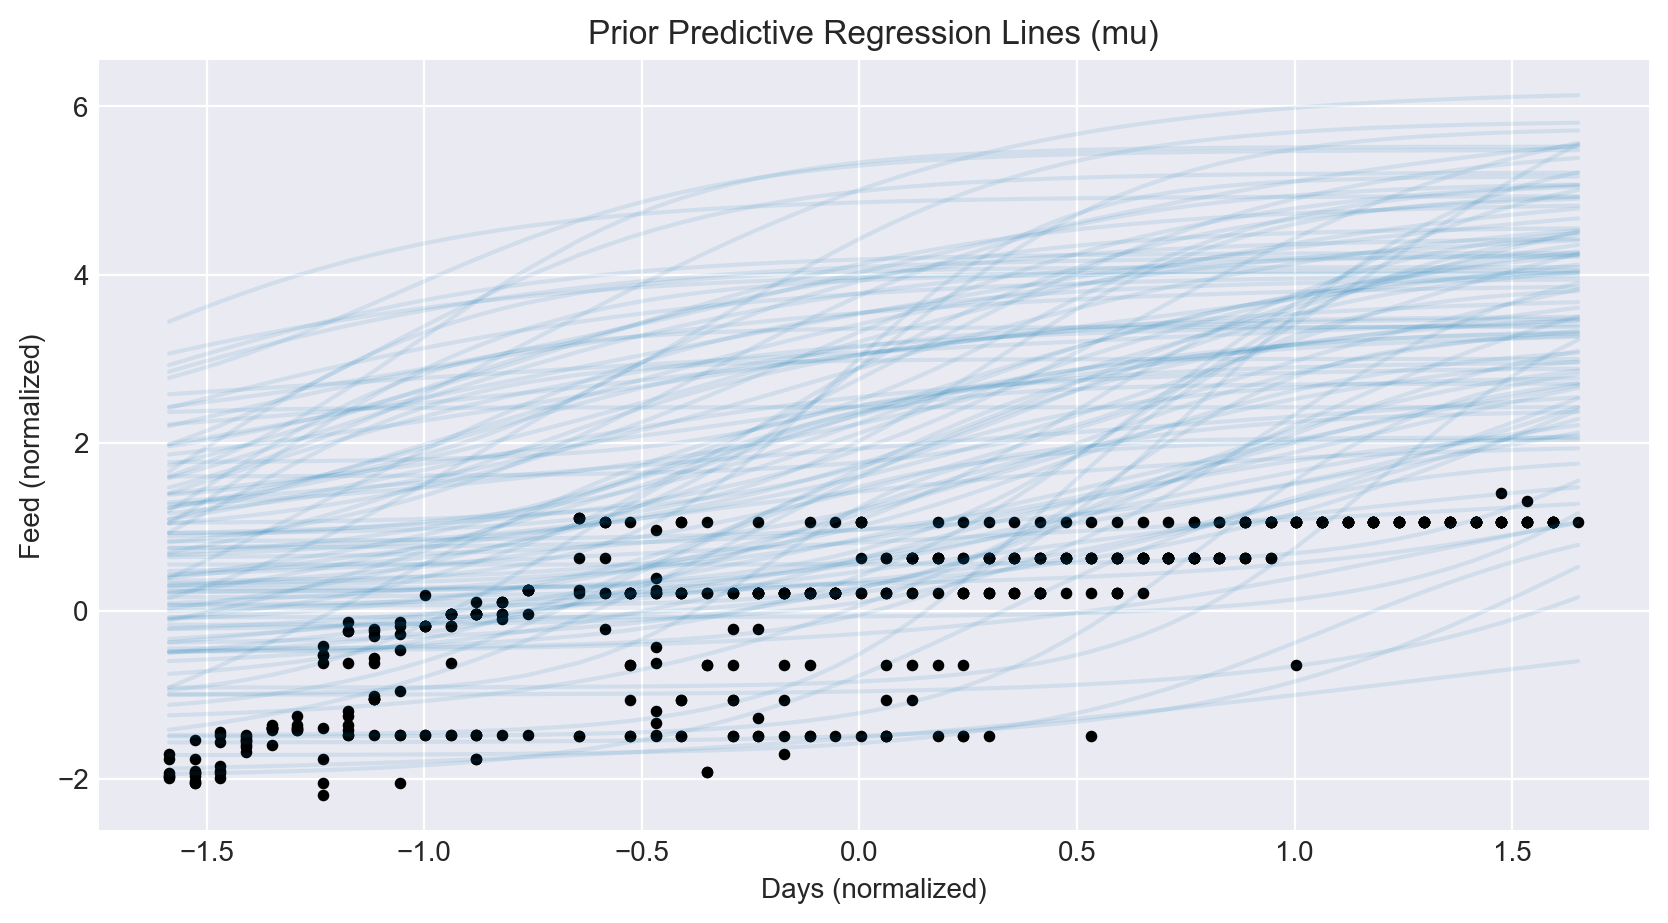

In [315]:
prior_mu = idata_eating.prior['mu'].values.reshape(100, -1)

plt.figure(figsize=(10, 5))
# Plot each of the 100 prior draws as a faint line
for i in range(100):
    plt.plot(baby_feed_df['Days_norm'], prior_mu[i], color='C0', alpha=0.1)

plt.scatter(baby_feed_df['Days_norm'], baby_feed_df['Feed_mL_norm'], color='black', s=10, label='Observed')
plt.title("Prior Predictive Regression Lines (mu)")
plt.xlabel("Days (normalized)")
plt.ylabel("Feed (normalized)")
plt.show()

In [316]:
with eating_model:
    idata_eating.extend(pm.sample(1000, tune=1000))
    idata_eating.extend(pm.sample_posterior_predictive(idata_eating))

C:\Users\dloso\miniconda3\envs\stats-ml\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, L, k, x0, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [feed]


Output()

## Model Fit and Issues
The model fit seems reasonable, however the maximum feed size appears rather small (mean L ~ 146 mL, 4.5 oz) as babies can eat 6+ ounces as they slowly wean off of bottle/breastfeeding. The likely culprit is the large amount of small feeds (<50 mL) that extend to the ~40 day mark. These were supplemental feeds given to the baby when the initial feed wasn't enough. A better model might be to fit the total amount of milk/formula eaten each day so that these nuances in feeding can be smoothed out.

In [317]:
az.summary(idata_eating, var_names=['L', 'x0', 'k', 'a'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L,4.219,0.500,3.305,5.170,0.014,0.012,1224.0,1231.0,1.0
x0,-0.762,0.230,-1.216,-0.356,0.006,0.004,1517.0,1450.0,1.0
k,1.013,0.142,0.754,1.277,0.004,0.003,1442.0,1621.0,1.0
a,-2.738,0.417,-3.560,-2.004,0.012,0.010,1279.0,1193.0,1.0


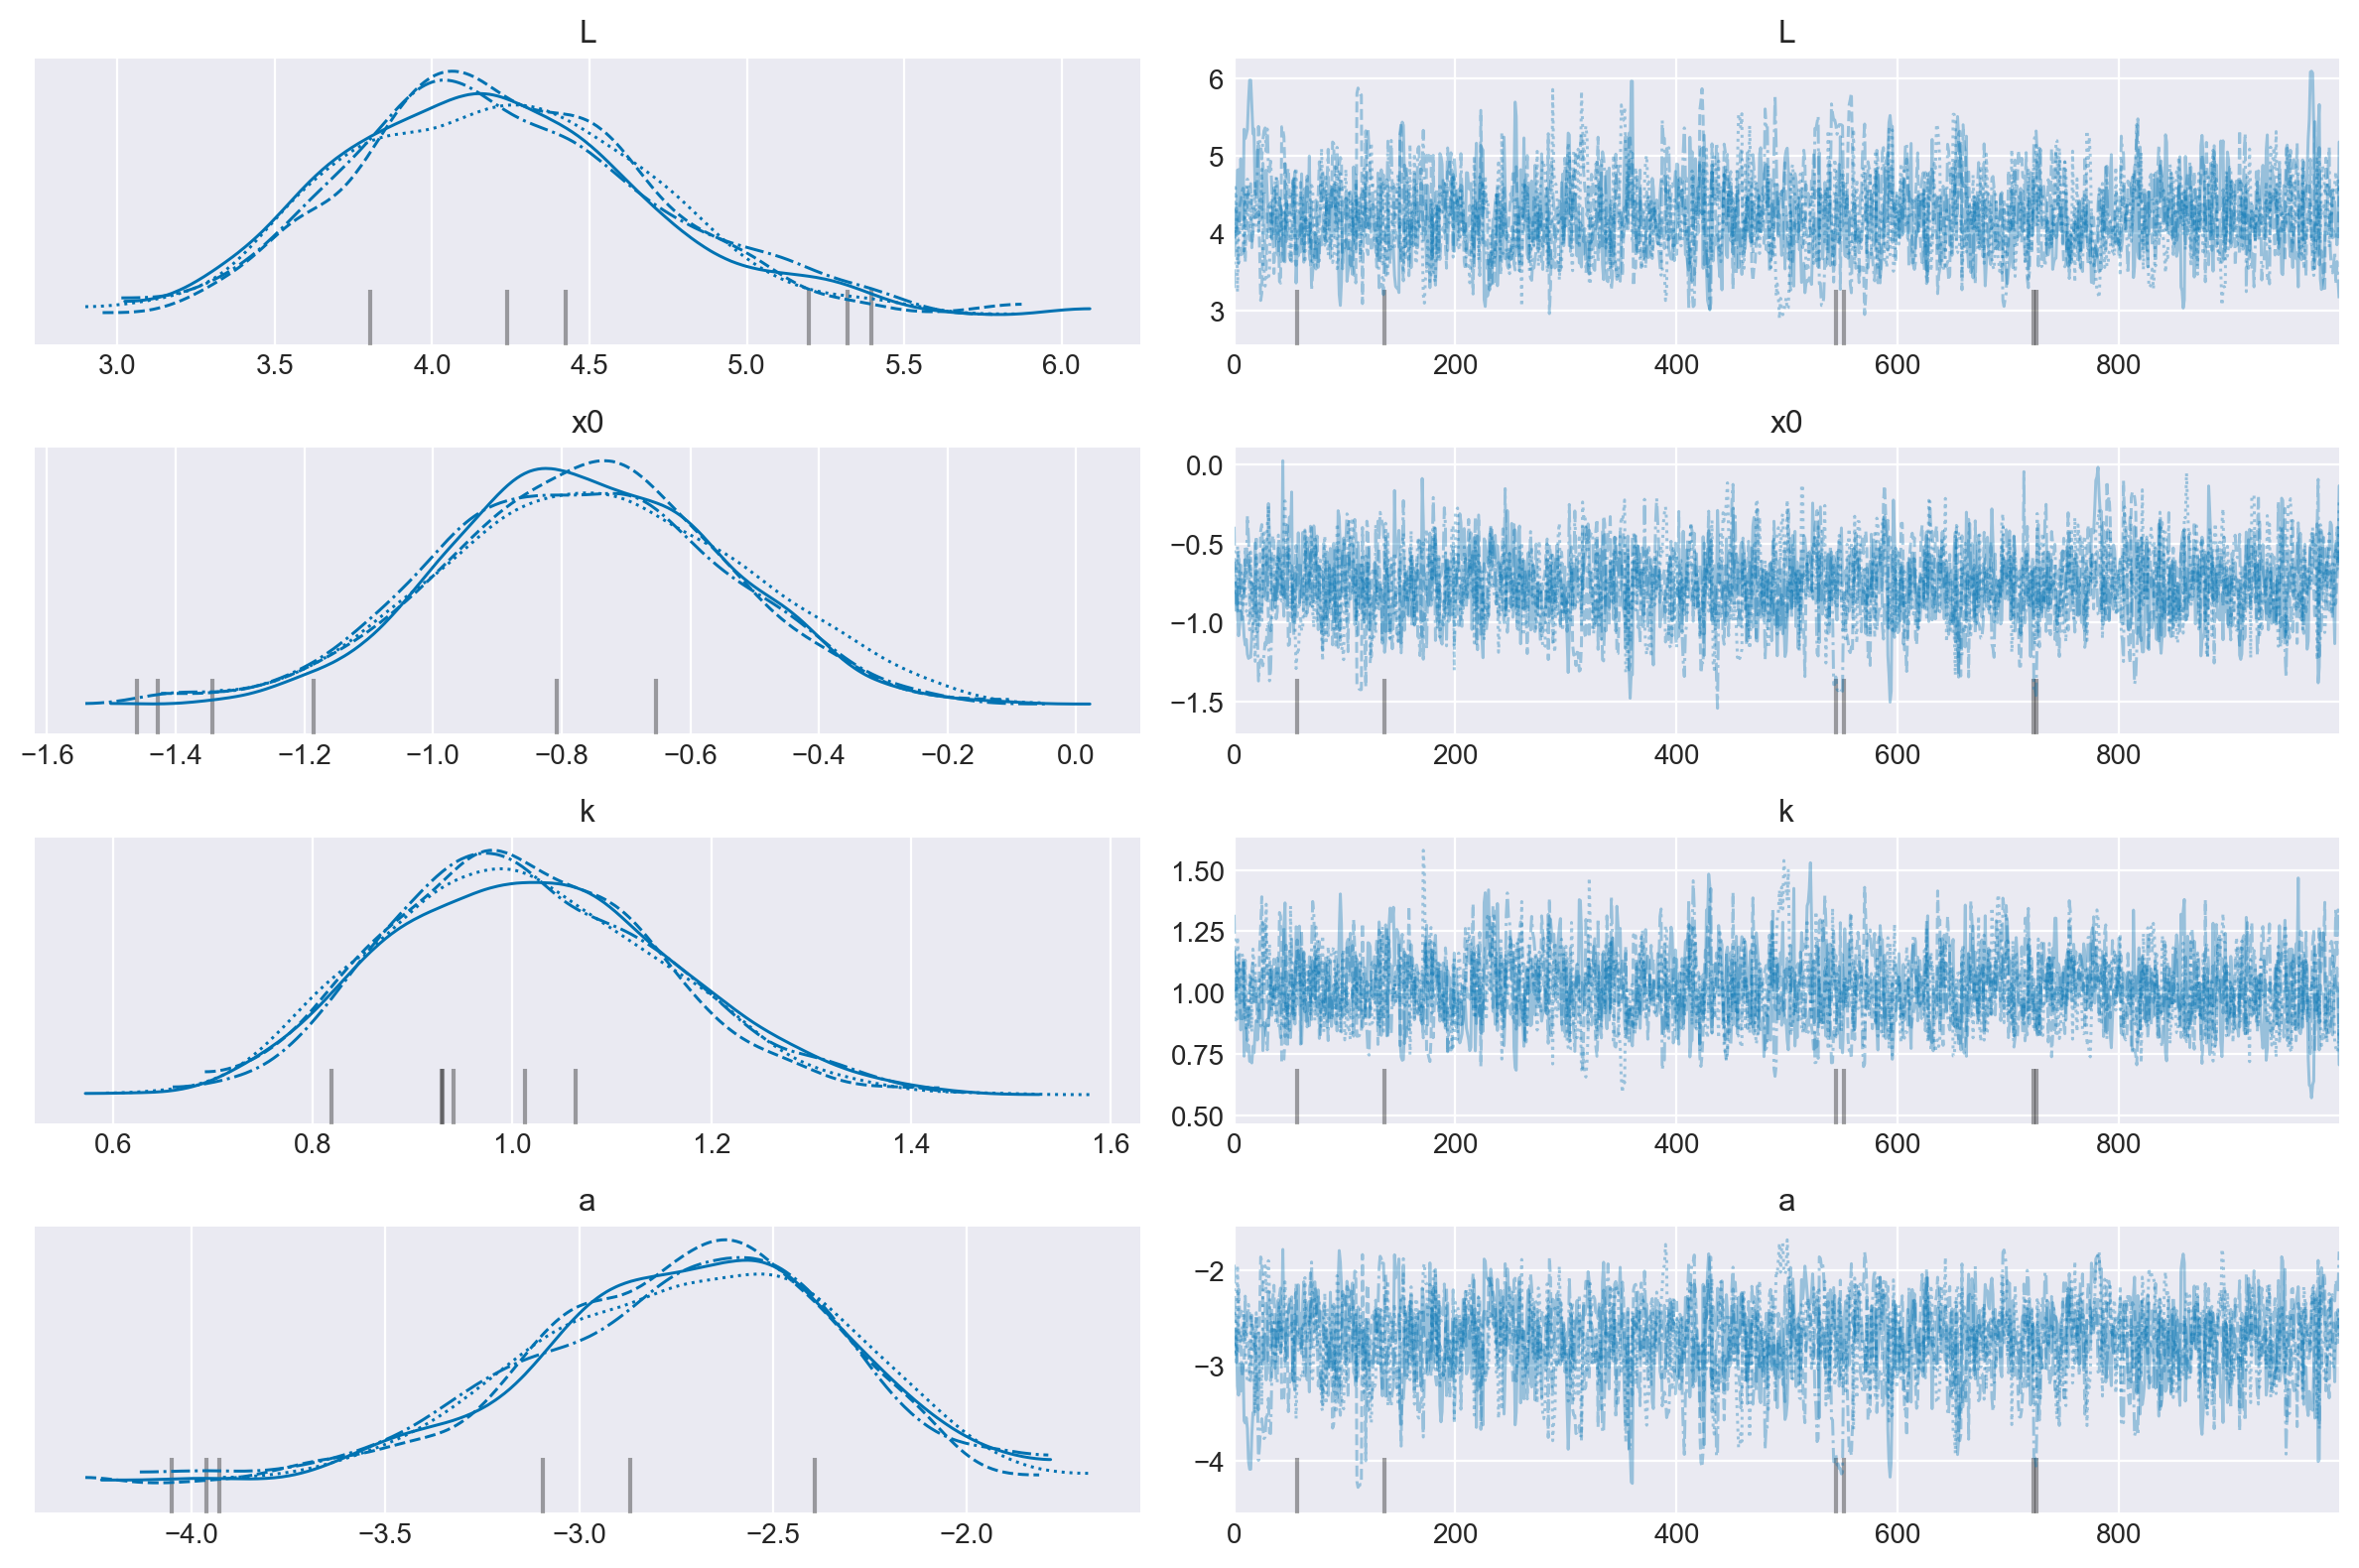

In [318]:
az.plot_trace(idata_eating, var_names=['L', 'x0', 'k', 'a'])
plt.tight_layout();

In [319]:
# Prep to convert data
days_std = baby_df['Days'].std()
days_mean = baby_df['Days'].mean()
feed_std = baby_df['Feed_mL'].std()
feed_mean = baby_df['Feed_mL'].mean()

# Convert data from normalized to original units
idata_eating.constant_data['days_original'] = idata_eating.constant_data['days'] * days_std + days_mean
idata_eating.observed_data['feed_original'] = idata_eating.observed_data['feed'] * feed_std + feed_mean
idata_eating.posterior['mu_original'] = idata_eating.posterior['mu'] * feed_std + feed_mean
idata_eating.posterior_predictive['feed_original'] = idata_eating.posterior_predictive['feed'] * feed_std + feed_mean

In [333]:
# Generate extra data to extend the prediction of the curve
days_ext = np.linspace(0, 200, 200)
days_ext_norm = (days_ext - days_mean) / days_std

with eating_model:
    pm.set_data({'days': days_ext_norm})
    ext_idata = pm.sample_posterior_predictive(idata_eating, predictions=True)

idata_plot = idata_eating.copy()
idata_plot.posterior_predictive['feed_original'] = ext_idata.predictions['feed'] * feed_std + feed_mean

Sampling: [feed]


Output()

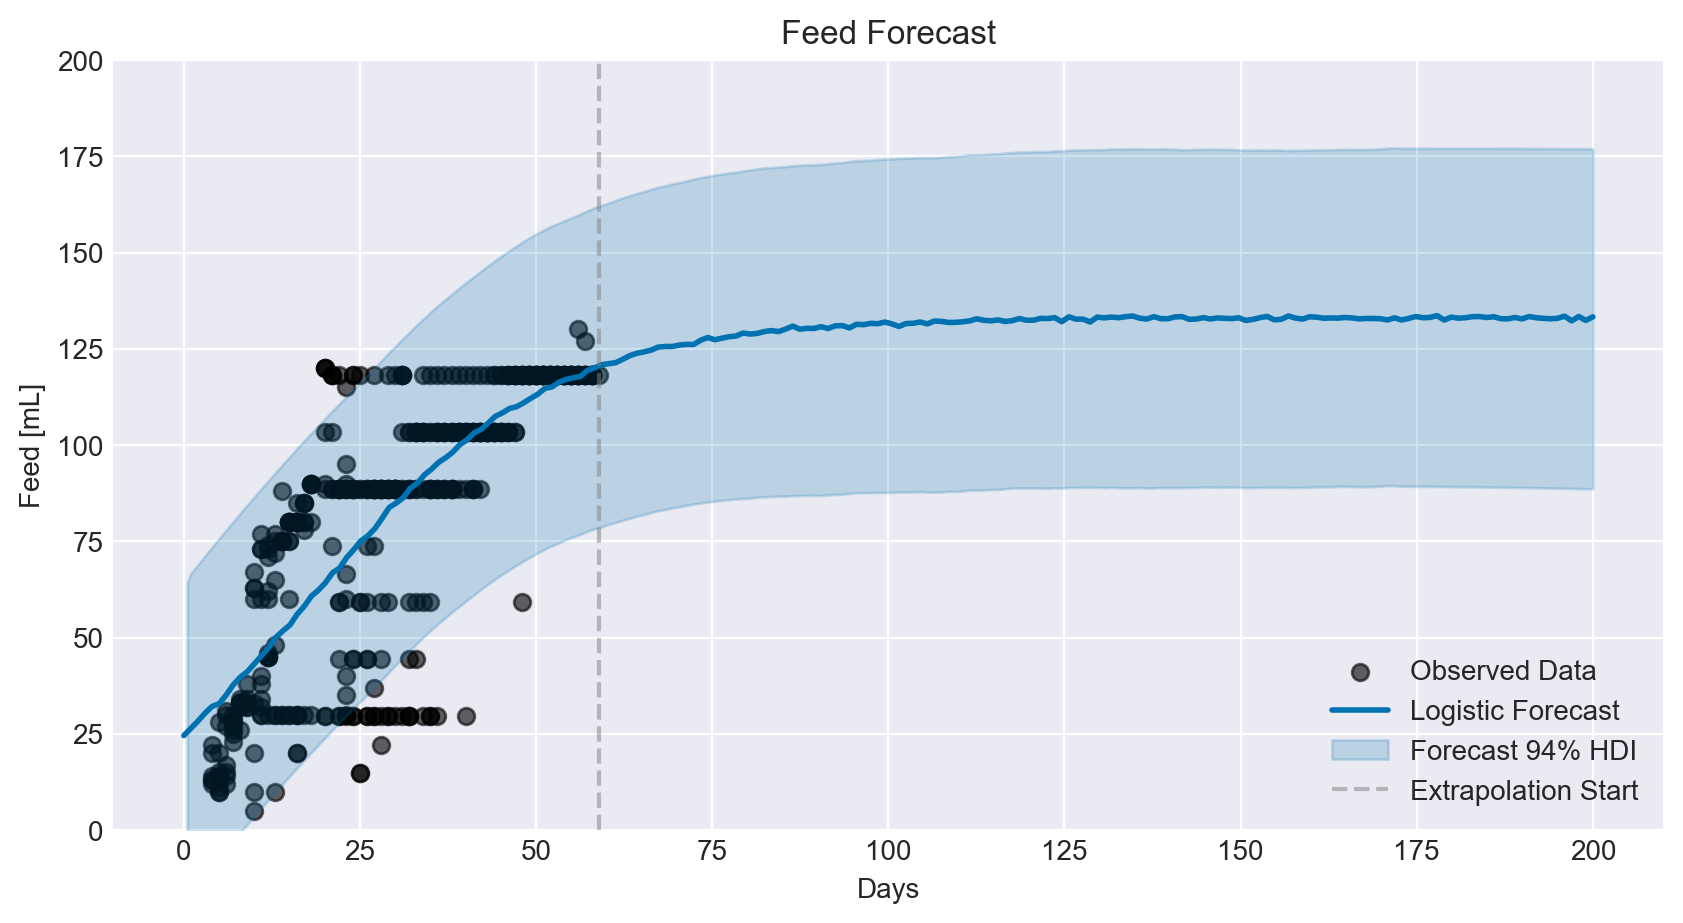

In [334]:
# Plot the model with extrapolation out to 200 days
mean_curve = ext_idata.predictions['feed'].mean(dim=['chain', 'draw']) * feed_std + feed_mean
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(baby_df['Days'], baby_df['Feed_mL'], color='black', alpha=0.6, label='Observed Data')
ax.plot(days_ext, mean_curve, color='C0', lw=2, label='Logistic Forecast')
az.plot_hdi(
    days_ext, 
    ext_idata.predictions['feed'] * feed_std + feed_mean, 
    ax=ax, 
    hdi_prob=0.94, 
    fill_kwargs={'alpha': 0.2, 'label': 'Forecast 94% HDI', 'color': 'C0'}
)
ax.axvline(baby_df['Days'].max(), color='grey', ls='--', alpha=0.5, label='Extrapolation Start')

ax.set_ylim(0, 200)
ax.set_xlabel('Days')
ax.set_ylabel('Feed [mL]')
ax.set_title('Feed Forecast')
ax.legend(loc='lower right')
plt.show()

## Feed Model Redux
Now I will refit the same model, but using the total feed volume per day. I will be dropping any 0 values since those are either due to breastfeeding or not recording the value due to tiredness, delirium, or some other new parent ailment.

## Priors 2
I have adjusted the priors slightly due to the changes in the distribution of y-data, but they are still roughly the same as in the original model.

In [344]:
feed_df = baby_df.groupby('Days')['Feed_mL'].sum().reset_index()
feed_day_mean = feed_df['Feed_mL'].mean()
feed_day_std = feed_df['Feed_mL'].std()
feed_df['Feed_mL_norm'] = (feed_df['Feed_mL'] - feed_day_mean) / feed_day_std
feed_df['Days_norm'] = (feed_df['Days'] - days_mean) / days_std
feed_df = feed_df[feed_df['Feed_mL'] > 0]

with pm.Model() as eating_model_2:
    days = pm.Data('days', feed_df['Days_norm'].values)
    feed_obs = pm.Data('feed_obs', feed_df['Feed_mL_norm'].values)

    a = pm.Normal('a', mu=-1, sigma=1)
    L = pm.TruncatedNormal('L', lower=1, mu=3, sigma=1)
    k = pm.TruncatedNormal('k', lower=0.3, mu=2, sigma=1)
    x0 = pm.Normal('x0', mu=0, sigma=1)
    
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', L / (1 + pm.math.exp(-k * (days - x0))) + a)
    feed = pm.Normal('feed', mu=mu, sigma=sigma, observed=feed_obs, shape=days.shape)

    idata_eating_2 = pm.sample_prior_predictive(draws=100)

Sampling: [L, a, feed, k, sigma, x0]


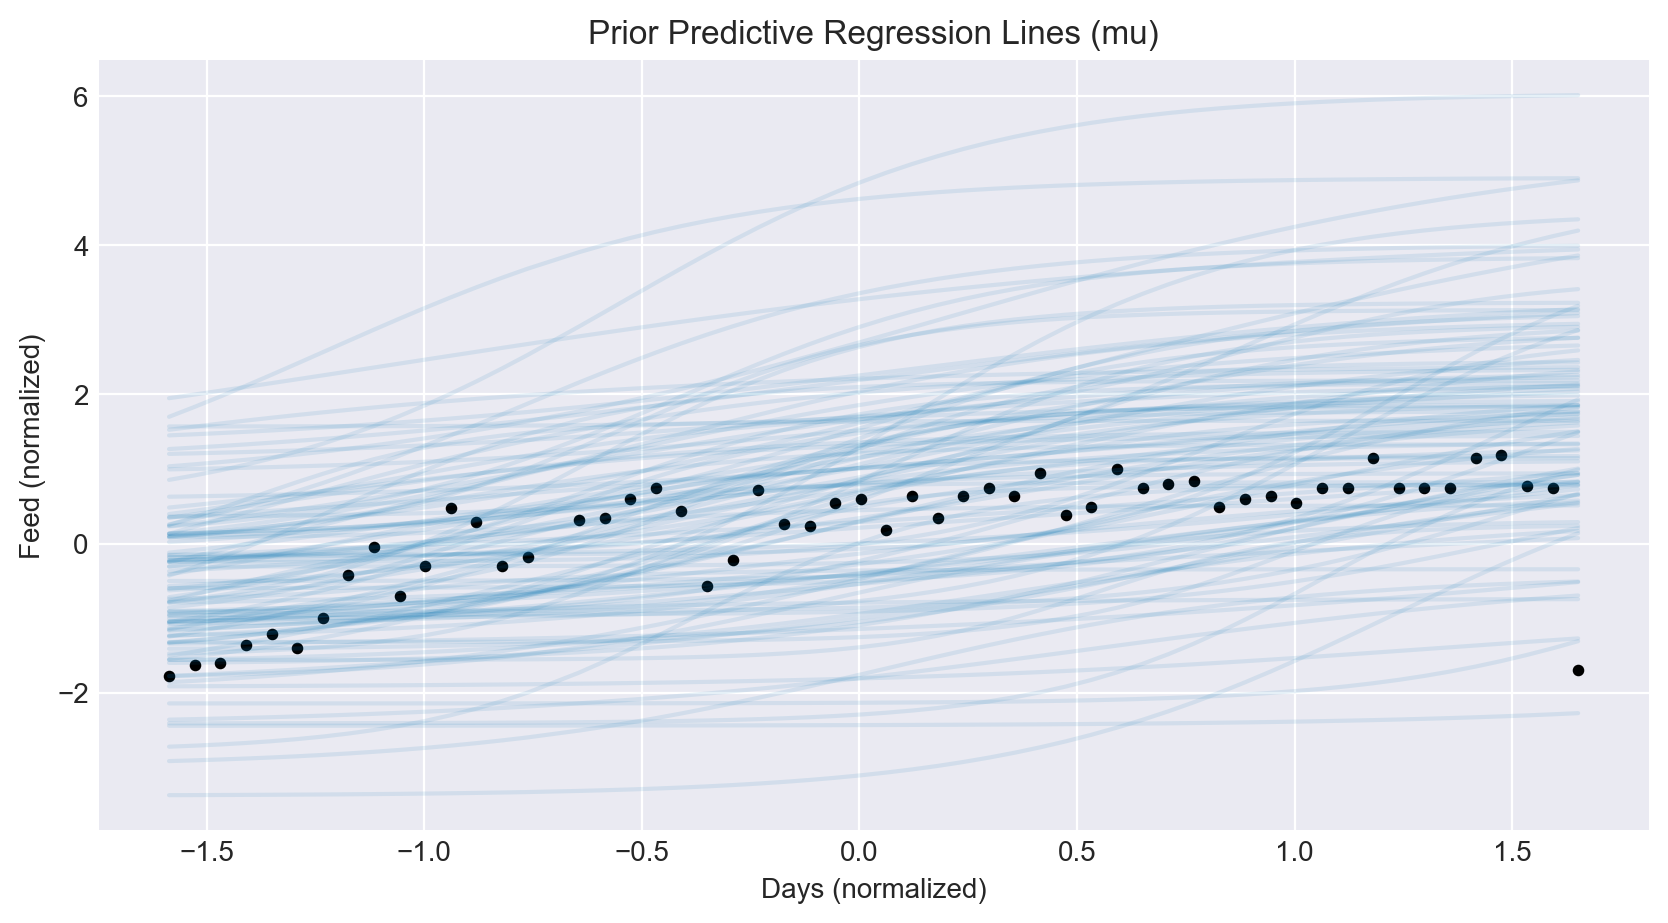

In [345]:
prior_mu_2 = idata_eating_2.prior['mu'].values.reshape(100, -1)

plt.figure(figsize=(10, 5))
# Plot each of the 100 prior draws as a faint line
for i in range(100):
    plt.plot(feed_df['Days_norm'], prior_mu_2[i], color='C0', alpha=0.1)

plt.scatter(feed_df['Days_norm'], feed_df['Feed_mL_norm'], color='black', s=10, label='Observed')
plt.title("Prior Predictive Regression Lines (mu)")
plt.xlabel("Days (normalized)")
plt.ylabel("Feed (normalized)")
plt.show()

## Model Fit 2
The model encounters a couple of divergences, but all parameters show rhats of 1 indicating good exploration of the parameters space. And, once again, the model shows a strong plateau, but the hdi encompmasses the approximate true value of 1 L (32 oz) of breastmilk/formula per day that most babies reach prior to starting solid foods. 

In [346]:
with eating_model_2:
    idata_eating_2.extend(pm.sample(1000, tune=1000))
    idata_eating_2.extend(pm.sample_posterior_predictive(idata_eating_2))

# Convert data from normalized to original units
idata_eating_2.constant_data['days_original'] = idata_eating_2.constant_data['days'] * days_std + days_mean
idata_eating_2.observed_data['feed_original'] = idata_eating_2.observed_data['feed'] * feed_day_std + feed_day_mean
idata_eating_2.posterior['mu_original'] = idata_eating_2.posterior['mu'] * feed_day_std + feed_day_mean
idata_eating_2.posterior_predictive['feed_original'] = idata_eating_2.posterior_predictive['feed'] * feed_day_std + feed_day_mean

with eating_model_2:
    pm.set_data({'days': days_ext_norm})
    ext_idata_2 = pm.sample_posterior_predictive(idata_eating_2, predictions=True)

idata_plot_2 = idata_eating_2.copy()
idata_plot_2.posterior_predictive['feed_original'] = ext_idata_2.predictions['feed'] * feed_day_std + feed_day_mean

C:\Users\dloso\miniconda3\envs\stats-ml\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, L, k, x0, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [feed]


Output()

Sampling: [feed]


Output()

In [347]:
az.summary(idata_eating_2, var_names=['L', 'x0', 'k', 'a'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L,3.005,0.491,2.116,3.936,0.017,0.013,886.0,753.0,1.00
x0,-1.231,0.133,-1.492,-0.983,0.004,0.003,998.0,1094.0,1.00
k,3.004,0.607,1.906,4.165,0.015,0.011,1713.0,2052.0,1.00
a,-2.374,0.485,-3.248,-1.436,0.017,0.013,862.0,738.0,1.01


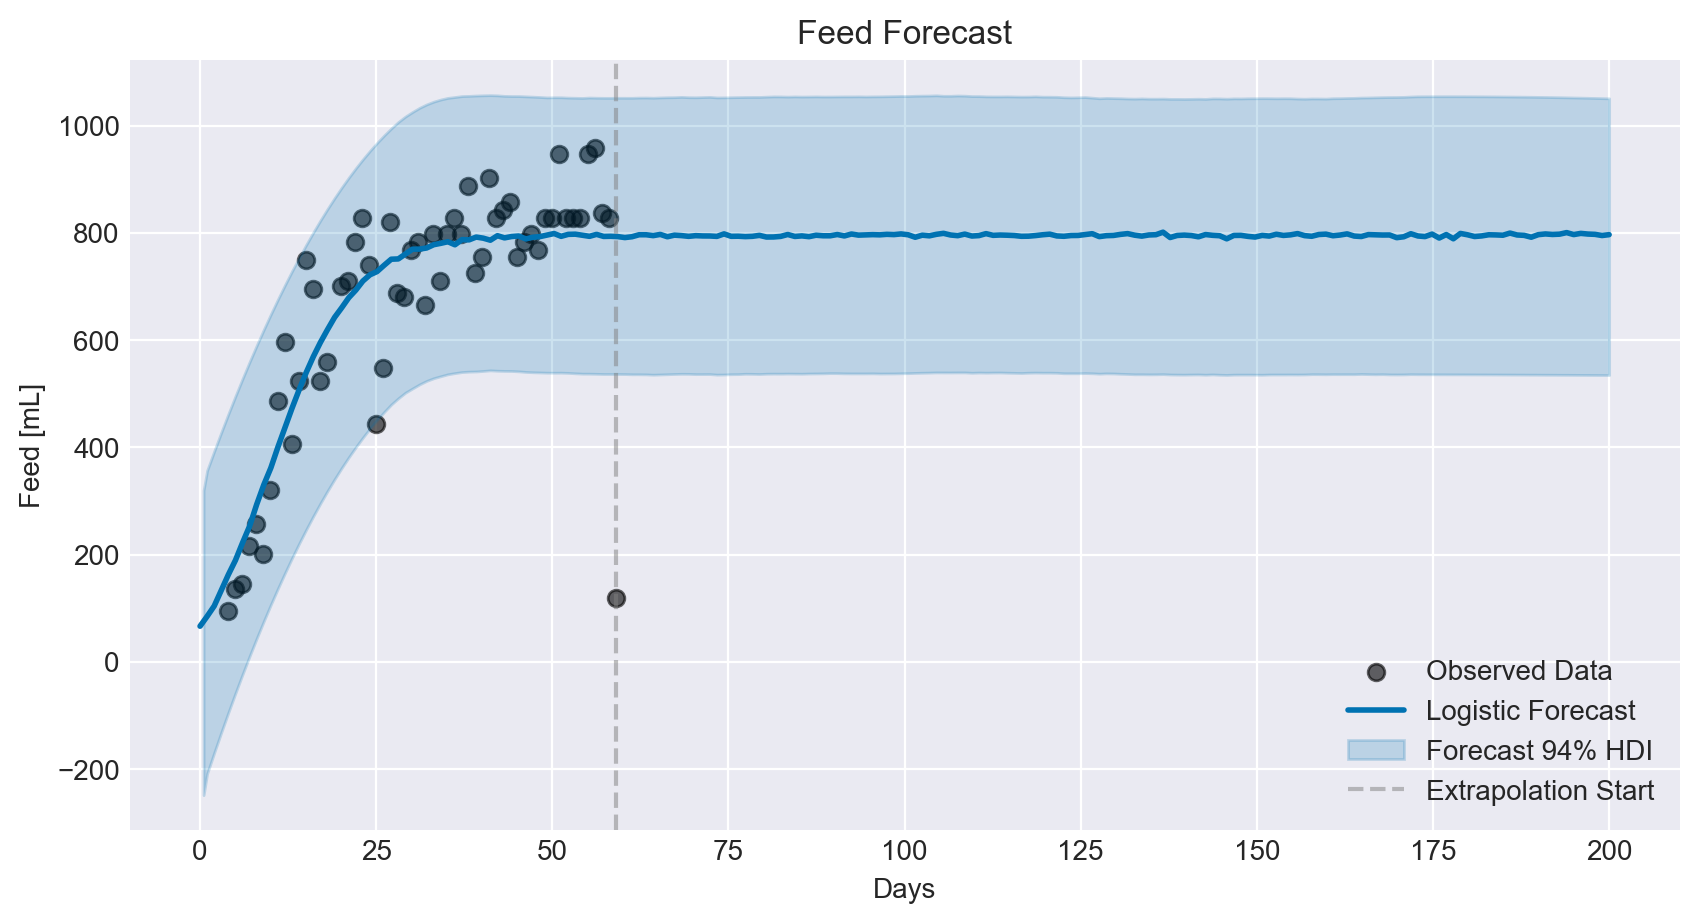

In [348]:
# Plot the model with extrapolation out to 200 days
mean_curve_2 = ext_idata_2.predictions['feed'].mean(dim=['chain', 'draw']) * feed_day_std + feed_day_mean
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(feed_df['Days'], feed_df['Feed_mL'], color='black', alpha=0.6, label='Observed Data')
ax.plot(days_ext, mean_curve_2, color='C0', lw=2, label='Logistic Forecast')
az.plot_hdi(
    days_ext, 
    ext_idata_2.predictions['feed'] * feed_day_std + feed_day_mean, 
    ax=ax, 
    hdi_prob=0.94, 
    fill_kwargs={'alpha': 0.2, 'label': 'Forecast 94% HDI', 'color': 'C0'}
)
ax.axvline(feed_df['Days'].max(), color='grey', ls='--', alpha=0.5, label='Extrapolation Start')

ax.set_xlabel('Days')
ax.set_ylabel('Feed [mL]')
ax.set_title('Feed Forecast')
ax.legend(loc='lower right')
plt.show()